In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import copy
import time

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def load_data(input_path):
    df = pd.read_csv(input_path)
    # Convert datetime column to datetime type
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

In [ ]:
def preprocess_data(df):
    # Sort by datetime
    df = df.sort_values('DateTime')

    # Extract time-based features
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month
    df['Year'] = df['DateTime'].dt.year

    # Create one-hot encoding for junction
    junction_dummies = pd.get_dummies(df['Junction'], prefix='Junction')
    df = pd.concat([df, junction_dummies], axis=1)

    return df

In [ ]:
class TrafficDataset(Dataset):
    def __init__(self, features, targets, seq_length):
        self.features = features
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

In [ ]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Split data by time (train on 2015-2016, validate on 2017)
def time_based_split(df):
    train_data = df[df['DateTime'].dt.year < 2017]
    val_data = df[df['DateTime'].dt.year == 2017]
    return train_data, val_data

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size

        # Change num_layers=1 (default) since we're handling multiple layers manually
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.gru2 = nn.GRU(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        # Initialize hidden states with num_layers=1 (default for GRU)
        h0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        h0_2 = torch.zeros(1, x.size(0), self.hidden_size // 2).to(x.device)

        # First GRU layer
        out, _ = self.gru1(x, h0_1)
        out = self.dropout1(out)

        # Second GRU layer
        out, _ = self.gru2(out, h0_2)
        out = self.dropout2(out)

        # Only take the output from the final time step
        out = out[:, -1, :]

        # Linear layer for prediction
        out = self.fc(out)
        return out

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
class ReduceLROnPlateauCustom:
    def __init__(self, optimizer, factor=0.2, patience=5, min_lr=0.0001):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = float('inf')

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f'Reducing learning rate from {old_lr} to {new_lr}')

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs=25):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update learning rate if needed
        scheduler.step(val_loss)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model
    model.load_state_dict(torch.load(early_stopping.path))

    return model, train_losses, val_losses

In [ ]:
def make_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.numpy())

    return np.array(predictions), np.array(actuals)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Loading and preprocessing data...
Train data shape: (30744, 12), Validation data shape: (17376, 12)
Training samples: 30720, Validation samples: 17352
GRUModel(
  (gru1): GRU(7, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (gru2): GRU(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Building and training GRU model...
Epoch [1/25], Train Loss: 0.0124, Validation Loss: 0.0337
Validation loss decreased (inf --> 0.033695). Saving model...
Epoch [2/25], Train Loss: 0.0113, Validation Loss: 0.0332
Validation loss decreased (0.033695 --> 0.033212). Saving model...
Epoch [3/25], Train Loss: 0.0108, Validation Loss: 0.0325
Validation loss decreased (0.033212 --> 0.032492). Saving model...
Epoch [4/25], Train Loss: 0.0105, Validatio

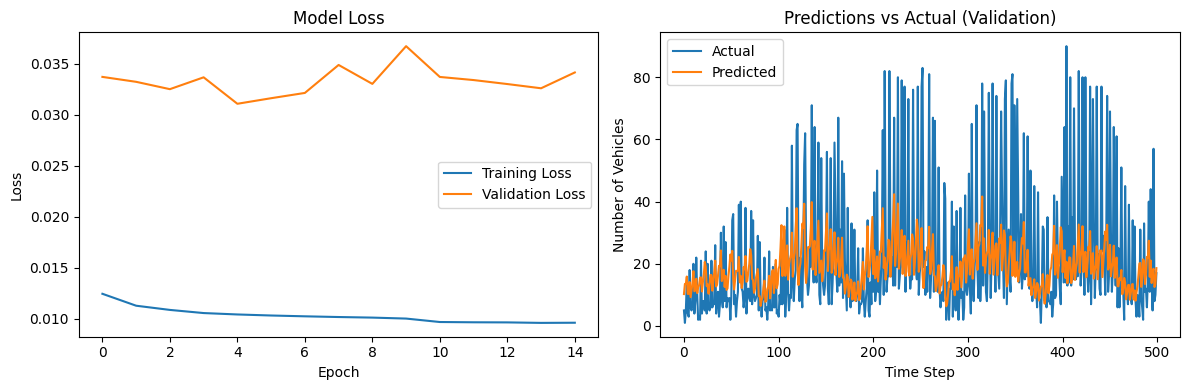

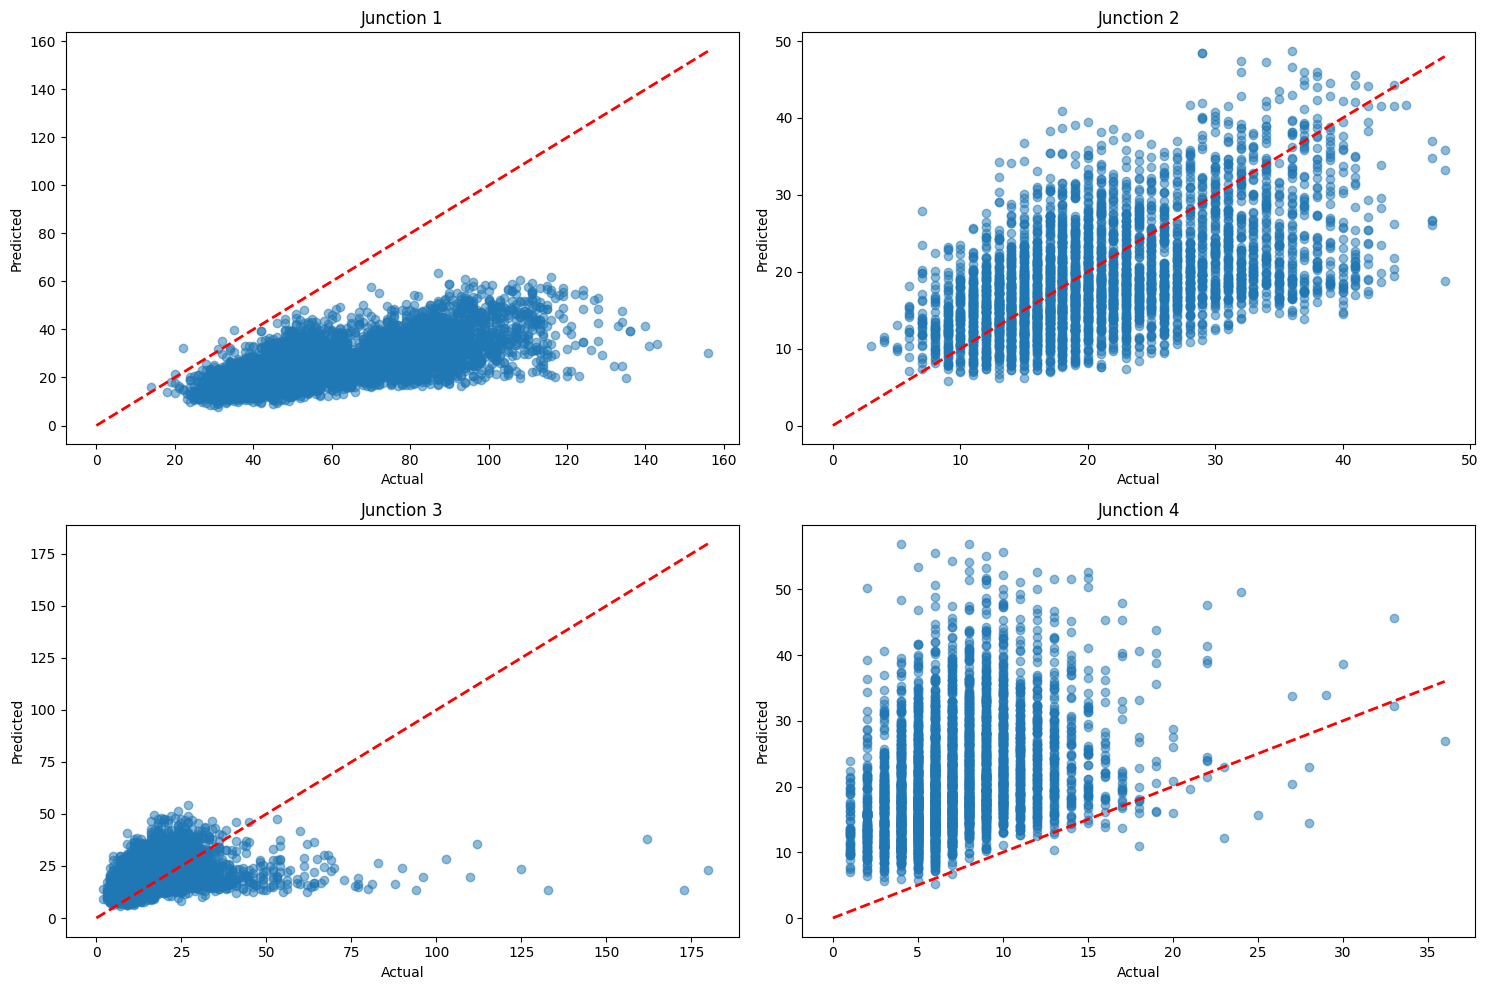

Model saved as 'traffic_gru_pytorch_model.pth'


In [ ]:
def main():
    # Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except:
        print("Not running in Google Colab or Drive already mounted.")

    # Load and preprocess data
    print("Loading and preprocessing data...")
    input_path = '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic.csv'
    try:
        df = load_data(input_path)
    except FileNotFoundError:
        print(f"File not found: {input_path}")
        print("Please adjust the path to your traffic.csv file")
        return

    df = preprocess_data(df)

    # Split data by time
    train_data, val_data = time_based_split(df)
    print(f"Train data shape: {train_data.shape}, Validation data shape: {val_data.shape}")

    # Select features and target
    feature_columns = ['Hour', 'DayOfWeek', 'Month', 'Junction_1',
                       'Junction_2', 'Junction_3', 'Junction_4']
    target_column = 'Vehicles'

    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit scalers on training data only
    train_features = scaler_X.fit_transform(train_data[feature_columns])
    train_target = scaler_y.fit_transform(train_data[[target_column]])

    # Transform validation data
    val_features = scaler_X.transform(val_data[feature_columns])
    val_target = scaler_y.transform(val_data[[target_column]])

    # Create datasets and dataloaders
    seq_length = 24  # Use 24 hours (1 day) of data to predict the next hour
    batch_size = 32

    train_dataset = TrafficDataset(train_features, train_target, seq_length)
    val_dataset = TrafficDataset(val_features, val_target, seq_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # Initialize model
    input_size = len(feature_columns)  # Number of features
    model = GRUModel(input_size=input_size).to(device)
    print(model)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(patience=10, path='traffic_gru_best_model.pth')
    scheduler = ReduceLROnPlateauCustom(optimizer, factor=0.2, patience=5, min_lr=0.0001)

    # Train the model
    print("Building and training GRU model...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs=25
    )

    # Make predictions
    print("Evaluating model...")
    train_preds, y_train = make_predictions(model, train_loader)
    val_preds, y_val = make_predictions(model, val_loader)

    # Reshape predictions for inverse transform
    train_preds = train_preds.reshape(-1, 1)
    val_preds = val_preds.reshape(-1, 1)

    # Reshape targets
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    # Inverse transform predictions and targets
    train_preds = scaler_y.inverse_transform(train_preds)
    val_preds = scaler_y.inverse_transform(val_preds)
    y_train_actual = scaler_y.inverse_transform(y_train)
    y_val_actual = scaler_y.inverse_transform(y_val)

    # Calculate metrics
    train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_preds))
    val_rmse = math.sqrt(mean_squared_error(y_val_actual, val_preds))
    train_r2 = r2_score(y_train_actual, train_preds)
    val_r2 = r2_score(y_val_actual, val_preds)

    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")
    print(f"Training R² Score: {train_r2:.4f}")
    print(f"Validation R² Score: {val_r2:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot predictions vs actual for a sample of validation data
    plt.subplot(1, 2, 2)
    sample_size = min(500, len(val_preds))
    plt.plot(y_val_actual[:sample_size], label='Actual')
    plt.plot(val_preds[:sample_size], label='Predicted')
    plt.title('Predictions vs Actual (Validation)')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Vehicles')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Get the original junction values for validation data
    val_junctions = val_data['Junction'].values[seq_length:seq_length+len(val_preds)]

    # Create a DataFrame for analysis
    results_df = pd.DataFrame({
        'Actual': y_val_actual.flatten(),
        'Predicted': val_preds.flatten(),
        'Junction': val_junctions
    })

    # Plot predictions by junction
    plt.figure(figsize=(15, 10))
    for i, junction in enumerate([1, 2, 3, 4]):
        junction_data = results_df[results_df['Junction'] == junction]
        if len(junction_data) > 0:
            plt.subplot(2, 2, i+1)
            plt.scatter(junction_data['Actual'], junction_data['Predicted'], alpha=0.5)
            plt.plot([0, max(junction_data['Actual'])], [0, max(junction_data['Actual'])],
                     'r--', linewidth=2)
            plt.title(f'Junction {junction}')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')

    plt.tight_layout()
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'traffic_gru_pytorch_model.pth')
    print("Model saved as 'traffic_gru_pytorch_model.pth'")

if __name__ == "__main__":
    main()